# Thermal analysis with 3D components

This example shows how to create a thermal analysis of an electronic package by
taking advantage of 3D components with advanced features added by PyAEDT.

Keywords: **Icepak**, **3D components**, **mesh regions**, **monitor objects**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

In [2]:
from ansys.aedt.core import Icepak, downloads

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory and download files

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")
package_temp_name, qfp_temp_name = downloads.download_icepak_3d_component(
    destination=temp_folder.name
)

## Create heatsink
Create an empty project in non-graphical mode.

In [5]:
ipk = Icepak(
    project=os.path.join(temp_folder.name, "Heatsink.aedt"),
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    close_on_exit=True,
    new_desktop=True,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_86f2564c-2c62-400c-95a7-50400c5893f0.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 54243


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 2304.


PyAEDT INFO: Project Heatsink has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'Icepak_629' of type Icepak.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/Heatsink.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/Heatsink.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.0


Remove the air region, which is present by default. An air region is not needed as the heatsink
is to be exported as a 3D component.

In [6]:
ipk.modeler["Region"].delete()

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


Define the heatsink using multiple boxes.

In [7]:
hs_base = ipk.modeler.create_box(
    origin=[0, 0, 0], sizes=[37.5, 37.5, 2], name="HS_Base"
)
hs_base.material_name = "Al-Extruded"
hs_fin = ipk.modeler.create_box(origin=[0, 0, 2], sizes=[37.5, 1, 18], name="HS_Fin1")
hs_fin.material_name = "Al-Extruded"
n_fins = 11
hs_fins = hs_fin.duplicate_along_line(vector=[0, 3.65, 0], clones=n_fins)

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


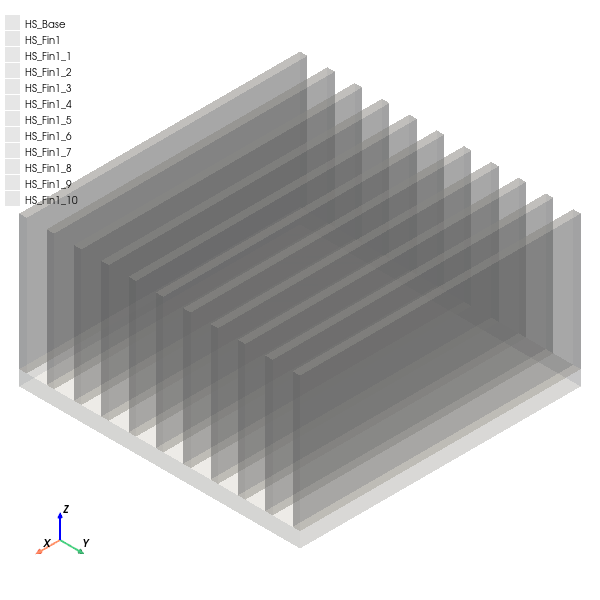

In [8]:
ipk.plot(show=False, output_file=os.path.join(temp_folder.name, "Heatsink.jpg"))

Define a mesh region around the heatsink.

In [9]:
mesh_region = ipk.mesh.assign_mesh_region(
    assignment=[hs_base.name, hs_fin.name] + hs_fins
)
mesh_region.manual_settings = True
mesh_region.settings["MaxElementSizeX"] = "5mm"
mesh_region.settings["MaxElementSizeY"] = "5mm"
mesh_region.settings["MaxElementSizeZ"] = "1mm"
mesh_region.settings["MinElementsInGap"] = 4
mesh_region.settings["MaxLevels"] = 2
mesh_region.settings["BufferLayers"] = 2
mesh_region.settings["EnableMLM"] = True
mesh_region.settings["UniformMeshParametersType"] = "Average"
mesh_region.update()

PyAEDT WARNING: No mesh operation found.


PyAEDT WARNING: No mesh region found.


PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec


True

Assign monitor objects.

In [10]:
hs_middle_fin = ipk.modeler.get_object_from_name(assignment=hs_fins[n_fins // 2])
point_monitor_position = [
    0.5 * (hs_base.bounding_box[i] + hs_base.bounding_box[i + 3]) for i in range(2)
] + [
    hs_middle_fin.bounding_box[-1]
]  # average x,y, top z
ipk.monitor.assign_point_monitor(
    point_position=point_monitor_position,
    monitor_quantity=["Temperature", "HeatFlux"],
    monitor_name="TopPoint",
)
ipk.monitor.assign_face_monitor(
    face_id=hs_base.bottom_face_z.id,
    monitor_quantity="Temperature",
    monitor_name="Bottom",
)
ipk.monitor.assign_point_monitor_in_object(
    name=hs_middle_fin.name,
    monitor_quantity="Temperature",
    monitor_name="MiddleFinCenter",
)

'MiddleFinCenter'

Export the heatsink 3D component to a ``"componentLibrary"`` folder.
The ``auxiliary_dict`` parameter is set to ``True`` to export the monitor objects
along with the A3DCOMP file.

In [11]:
os.mkdir(os.path.join(temp_folder.name, "componentLibrary"))
ipk.modeler.create_3dcomponent(
    input_file=os.path.join(temp_folder.name, "componentLibrary", "Heatsink.a3dcomp"),
    name="Heatsink",
    export_auxiliary=True,
)
ipk.close_project(save=False)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 2304!


PyAEDT INFO: Project temp_proj has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'Icepak_SPJ' of type Icepak.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/Heatsink.pyaedt/Icepak_629/config_export_temp_project/pyaedt_prj_PC4/temp_proj.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/Heatsink.pyaedt/Icepak_629/config_export_temp_project/pyaedt_prj_PC4/temp_proj.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015618324279785156


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/Heatsink.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/Heatsink.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.0


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Deleted 12 Objects: HS_Base,HS_Fin1_7,HS_Fin1_6,HS_Fin1_5,HS_Fin1_4,HS_Fin1_9,HS_Fin1_3,HS_Fin1_10,HS_Fin1_2,HS_Fin1_1,HS_Fin1,HS_Fin1_8.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Closing the AEDT Project temp_proj


PyAEDT INFO: Project temp_proj closed correctly


PyAEDT INFO: C:\Users\ansys\AppData\Local\Temp\tmpxurznmgd.ansys\Heatsink.pyaedt\Icepak_629\Icepak_629_B7TTKQ.json correctly created.


PyAEDT INFO: Json file C:\Users\ansys\AppData\Local\Temp\tmpxurznmgd.ansys\Heatsink.pyaedt\Icepak_629\Icepak_629_B7TTKQ.json created correctly.


PyAEDT INFO: Closing the AEDT Project Heatsink


PyAEDT INFO: Project Heatsink closed correctly


True

## Create QFP
Open the previously downloaded project containing a QPF.

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpxurznmgd.ansys\icepak_3dcomp\QFP2.aedt.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 2304!


PyAEDT INFO: Project QFP2 has been opened.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpxurznmgd.ansys\icepak_3dcomp\QFP2.aedt correctly loaded. Elapsed time: 0m 7sec


PyAEDT INFO: Active Design set to QFP2_Model


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


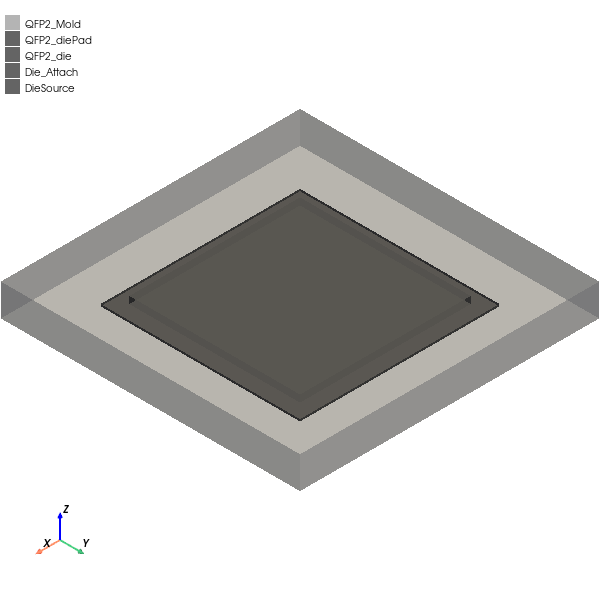

In [12]:
ipk = Icepak(project=qfp_temp_name, version=AEDT_VERSION)
ipk.plot(show=False, output_file=os.path.join(temp_folder.name, "QFP2.jpg"))

Create a dataset for power dissipation.

In [13]:
x_datalist = [45, 53, 60, 70]
y_datalist = [0.5, 3, 6, 9]
ipk.create_dataset(
    name="PowerDissipationDataset",
    x=x_datalist,
    y=y_datalist,
    is_project_dataset=False,
    x_unit="cel",
    y_unit="W",
)

PyAEDT INFO: Dataset PowerDissipationDataset doesn't exist.


PyAEDT INFO: Dataset PowerDissipationDataset created successfully.


Assign a source power condition to the die.

In [14]:
ipk.create_source_power(
    face_id="DieSource",
    thermal_dependent_dataset="PowerDissipationDataset",
    source_name="DieSource",
)

Assign thickness to the die attach surface.

In [15]:
ipk.assign_conducting_plate_with_thickness(
    obj_plate="Die_Attach",
    shell_conduction=True,
    thickness="0.05mm",
    solid_material="Epoxy Resin-Typical",
    boundary_name="Die_Attach",
)

Assign monitor objects.

In [16]:
ipk.monitor.assign_point_monitor_in_object(
    name="QFP2_die", monitor_quantity="Temperature", monitor_name="DieCenter"
)
ipk.monitor.assign_surface_monitor(
    surface_name="Die_Attach", monitor_quantity="Temperature", monitor_name="DieAttach"
)

'DieAttach'

Export the QFP 3D component in the ``"componentLibrary"`` folder and close the project.
Here the auxiliary dictionary allows exporting not only the monitor objects but also the dataset
used for the power source assignment.

In [17]:
ipk.modeler.create_3dcomponent(
    input_file=os.path.join(temp_folder.name, "componentLibrary", "QFP.a3dcomp"),
    name="QFP",
    export_auxiliary=True,
    datasets=["PowerDissipationDataset"],
)
ipk.release_desktop(close_projects=False, close_desktop=False)

PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 2304!


PyAEDT INFO: Project temp_proj has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'Icepak_2BY' of type Icepak.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/icepak_3dcomp/QFP2.pyaedt/QFP2_Model/config_export_temp_project/pyaedt_prj_PMC/temp_proj.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/icepak_3dcomp/QFP2.pyaedt/QFP2_Model/config_export_temp_project/pyaedt_prj_PMC/temp_proj.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015517473220825195


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/icepak_3dcomp/QFP2.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/icepak_3dcomp/QFP2.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.01563286781311035


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Deleted 5 Objects: Die_Attach,QFP2_die,QFP2_diePad,QFP2_Mold,DieSource.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Closing the AEDT Project temp_proj


PyAEDT INFO: Project temp_proj closed correctly


PyAEDT INFO: C:\Users\ansys\AppData\Local\Temp\tmpxurznmgd.ansys\icepak_3dcomp\QFP2.pyaedt\QFP2_Model\QFP2_Model_1J62WY.json correctly created.


PyAEDT INFO: Json file C:\Users\ansys\AppData\Local\Temp\tmpxurznmgd.ansys\icepak_3dcomp\QFP2.pyaedt\QFP2_Model\QFP2_Model_1J62WY.json created correctly.


PyAEDT INFO: Desktop has been released and closed.


True

## Create complete electronic package
Download and open a project containing the electronic package.

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpxurznmgd.ansys\icepak_3dcomp\PCBAssembly.aedt.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_86f2564c-2c62-400c-95a7-50400c5893f0.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 54340


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpxurznmgd.ansys\icepak_3dcomp\PCBAssembly.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 3796.


PyAEDT INFO: Project PCBAssembly has been opened.


PyAEDT INFO: Active Design set to Model


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


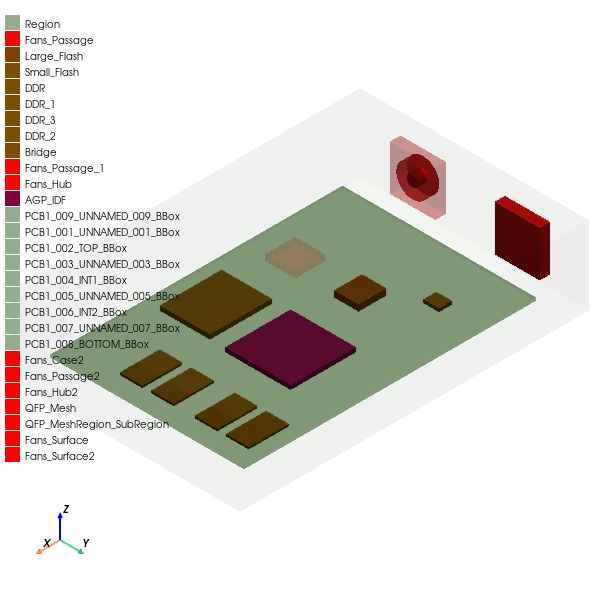

In [18]:
ipk = Icepak(
    project=package_temp_name,
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
)
ipk.plot(
    assignment=[o for o in ipk.modeler.object_names if not o.startswith("DomainBox")],
    show=False,
    output_file=os.path.join(temp_folder.name, "electronic_package_missing_obj.jpg"),
)

The heatsink and the QFP are missing. They can be inserted as 3D components.
The auxiliary files are needed because the goal is to also import monitor objects and datasets.

Create a coordinate system for the heatsink so that it is placed on top of the AGP.

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 3796!


PyAEDT INFO: Project Project_1DF has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'Icepak_VWS' of type Icepak.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/pyaedt_prj_VPW/Project_1DF.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/pyaedt_prj_VPW/Project_1DF.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.0


PyAEDT INFO: Closing the AEDT Project Project_1DF


PyAEDT INFO: Project Project_1DF closed correctly


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/icepak_3dcomp/PCBAssembly.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/icepak_3dcomp/PCBAssembly.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.221421480178833


PyAEDT INFO: Dataset PowerDissipationDataset exists.


PyAEDT WARNING: Dataset PowerDissipationDataset already exists


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 3796!


PyAEDT INFO: Project Project_Y5C has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'Icepak_XLC' of type Icepak.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/pyaedt_prj_ITF/Project_Y5C.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/pyaedt_prj_ITF/Project_Y5C.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.0


PyAEDT INFO: Closing the AEDT Project Project_Y5C


PyAEDT INFO: Project Project_Y5C closed correctly


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


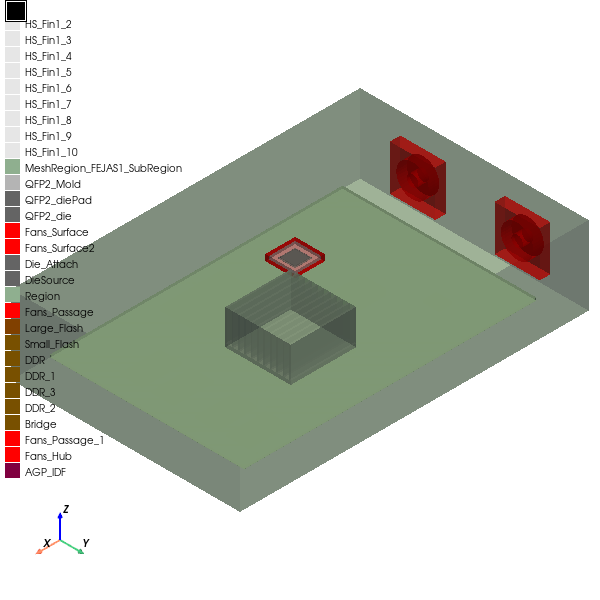

In [19]:
agp = ipk.modeler.get_object_from_name(assignment="AGP_IDF")
cs = ipk.modeler.create_coordinate_system(
    origin=[agp.bounding_box[0], agp.bounding_box[1], agp.bounding_box[-1]],
    name="HeatsinkCS",
    reference_cs="Global",
    x_pointing=[1, 0, 0],
    y_pointing=[0, 1, 0],
)
heatsink_obj = ipk.modeler.insert_3d_component(
    input_file=os.path.join(temp_folder.name, "componentLibrary", "Heatsink.a3dcomp"),
    coordinate_system="HeatsinkCS",
    auxiliary_parameters=True,
)

QFP2_obj = ipk.modeler.insert_3d_component(
    input_file=os.path.join(temp_folder.name, "componentLibrary", "QFP.a3dcomp"),
    coordinate_system="Global",
    auxiliary_parameters=True,
)

ipk.plot(
    assignment=[o for o in ipk.modeler.object_names if not o.startswith("DomainBox")],
    show=False,
    plot_air_objects=False,
    output_file=os.path.join(temp_folder.name, "electronic_package.jpg"),
    force_opacity_value=0.5,
)

Create a coordinate system at the xmin, ymin, and zmin of the model.

In [20]:
bounding_box = ipk.modeler.get_model_bounding_box()
cs_pcb_assembly = ipk.modeler.create_coordinate_system(
    origin=[bounding_box[0], bounding_box[1], bounding_box[2]],
    name="PCB_Assembly",
    reference_cs="Global",
    x_pointing=[1, 0, 0],
    y_pointing=[0, 1, 0],
)

Export the entire assembly as a 3D component and close the project. First, the nested
hierarchy must be flattened because nested 3D components are currently not supported. Subsequently,
the whole package can be exported as a 3D component. The auxiliary dictionary is needed
to export monitor objects, datasets, and native components.

In [21]:
ipk.flatten_3d_components()

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/icepak_3dcomp/PCBAssembly.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/icepak_3dcomp/PCBAssembly.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.22140002250671387


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 3796!


PyAEDT INFO: Project Heatsink set to active.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Parsing C:/Users/ansys/Documents/Ansoft/Heatsink.aedt.


PyAEDT INFO: File C:/Users/ansys/Documents/Ansoft/Heatsink.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.06260013580322266


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Closing the AEDT Project Heatsink


PyAEDT INFO: Project Heatsink closed correctly


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 3796!


PyAEDT INFO: Project Heatsink set to active.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Parsing C:/Users/ansys/Documents/Ansoft/Heatsink.aedt.


PyAEDT INFO: File C:/Users/ansys/Documents/Ansoft/Heatsink.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.03242373466491699


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/icepak_3dcomp/PCBAssembly.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpxurznmgd.ansys/icepak_3dcomp/PCBAssembly.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.22108674049377441


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Parsing C:/Users/ansys/Documents/Ansoft/Heatsink.aedt.


PyAEDT INFO: File C:/Users/ansys/Documents/Ansoft/Heatsink.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.01562952995300293


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Heatsink1_Bottom monitor object lost its assignment due to geometry modifications and has been deleted.


PyAEDT INFO: Heatsink1_MiddleFinCenter monitor object lost its assignment due to geometry modifications and has been deleted.


PyAEDT INFO: Heatsink1_Bottom monitor object restored


PyAEDT INFO: Heatsink1_MiddleFinCenter monitor object restored


PyAEDT INFO: Closing the AEDT Project Heatsink


PyAEDT INFO: Project Heatsink closed correctly


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 3796!


PyAEDT INFO: Project QFP set to active.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Parsing C:/Users/ansys/Documents/Ansoft/QFP.aedt.


PyAEDT INFO: File C:/Users/ansys/Documents/Ansoft/QFP.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.03253006935119629


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Closing the AEDT Project QFP


PyAEDT INFO: Project QFP closed correctly


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 3796!


PyAEDT INFO: Project QFP set to active.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Parsing C:/Users/ansys/Documents/Ansoft/QFP.aedt.


PyAEDT INFO: File C:/Users/ansys/Documents/Ansoft/QFP.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.03280758857727051


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: QFP1_DieAttach monitor object lost its assignment due to geometry modifications and has been deleted.


PyAEDT INFO: QFP1_DieCenter monitor object lost its assignment due to geometry modifications and has been deleted.


PyAEDT INFO: QFP1_DieAttach monitor object restored


PyAEDT INFO: QFP1_DieCenter monitor object restored


PyAEDT INFO: Closing the AEDT Project QFP


PyAEDT INFO: Project QFP closed correctly


True

## Release AEDT

In [22]:
ipk.save_project()
ipk.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project PCBAssembly Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [23]:
temp_folder.cleanup()